In [1]:
# Libraries

import os
import platform
import shutil
import sys

In [2]:
# Ensure source path

ROOT = os.getcwd()

while not ROOT.endswith('upolanc-thesis') :
	ROOT = os.path.abspath(os.path.join(ROOT, os.pardir))

	if len(ROOT) < len('upolanc-thesis') :
		if   platform.system() == 'Linux'   : ROOT = '/d/hpc/projects/FRI/up4472/upolanc-thesis'
		elif platform.system() == 'Windows' : ROOT = 'C:\\Developer\\Workspace\\PyCharm\\Projects\\upolanc-thesis'
		else : raise ValueError()

		print(f'Warning : could not find correct directory, using default : {ROOT}')
		print()

		break

if ROOT not in sys.path :
	sys.path.append(ROOT)

os.chdir(ROOT)

In [3]:
# Code

from source.python.report import report_load
from source.python.report import report_concat
from source.python.report import report_filter
from source.python.report import report_plot
from source.python.io     import loader
from source.python.io     import writer
from source.python        import runtime

runtime.set_numpy_format()
runtime.set_pandas_format()
runtime.set_plot_theme()

In [4]:
# List reports folder content

ROOT_DIR = os.path.join(ROOT, 'reports', '2023-06-xx')
DATA_DIR = os.path.join(ROOT, 'output', 'nbp13-report')

shutil.rmtree(DATA_DIR, ignore_errors = True)
os.makedirs(DATA_DIR, exist_ok = True)

for index, name in enumerate(os.listdir(ROOT_DIR), start = 0) :
	path_l0 = os.path.join(ROOT_DIR, name)

	if index == 0 : print('{} :'.format(path_l0))
	else          : print('\n{} :'.format(path_l0))

	for name in os.listdir(path_l0) :
		print('...\\{}'.format(name))

	print()

C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\reports\2023-06-xx\regression-bert :
...\fc3-cat-v1-12-3-72-po0512-adam-f2-0250-global-mean
...\fc3-cat-v1-12-3-72-po0512-adam-f3-0250-global-mean
...\fc3-def-v1-12-3-72-po0512-adam-f2-0250-global-mean
...\fc3-def-v1-12-3-72-po0512-adam-f2-0250-tissue-mean-explode
...\fc3-def-v1-12-3-72-po0512-adam-f3-0250-global-mean
...\fc3-def-v1-12-6-72-po0512-adam-f2-0250-global-mean
...\fc3-def-v2-12-3-72-po0512-adam-f2-0250-global-mean
...\fc3-rnn-v1-12-3-72-po0512-adam-f2-0250-global-mean
...\fc3-rnn-v1-12-3-72-po0512-adam-f2-0250-tissue-mean-seedling
...\fc3-rnn-v1-12-3-72-po0512-adam-f3-0250-global-mean
...\fc3-rnn-v1-12-3-72-po0512-adam-f3-0250-tissue-mean-explode
...\fc3-rnn-v1-12-3-72-po0512-adam-f3-0250-tissue-mean-seedling
...\fc3-rnn-v1-12-3-72-po4096-adam-f2-0250-global-mean
...\fc3-rnn-v1-12-3-72-po4096-adam-f2-0250-tissue-mean-explode
...\fc3-rnn-v1-12-3-72-po4096-adam-f2-0250-tissue-mean-seedling
...\fc3-rnn-v1-12-3-72-po4096-ad

In [5]:
# Load existing configurations

CONFIG_DIR = os.path.join(ROOT, 'resources', 'tuner')

ZCONFIG_PATH = os.path.join(CONFIG_DIR, 'zrimec.json')
WCONFIG_PATH = os.path.join(CONFIG_DIR, 'washburn.json')

ZCONFIG = list()
WCONFIG = list()

CONFIG_MAX       = 100
CONFIG_BEST      = 10
CONFIG_OVERWRITE = True
CONFIG_EXTEND    = False

if os.path.exists(ZCONFIG_PATH) and CONFIG_EXTEND :
	ZCONFIG = loader.load_json(filename = ZCONFIG_PATH)

	print('Sucessufully loaded configuration [{:88s}] with [{:2d}] elements'.format(ZCONFIG_PATH, len(ZCONFIG)))
	print()

if os.path.exists(WCONFIG_PATH) and CONFIG_EXTEND :
	WCONFIG = loader.load_json(filename = WCONFIG_PATH)

	print('Sucessufully loader configuration [{:88s}] with [{:2d}] elements'.format(WCONFIG_PATH, len(WCONFIG)))
	print()

# 1. Tuner

## 1.1 Model

In [6]:
# Load tune model reports

report_tune_model = report_load.load_cnn_tune_reports(
	root = ROOT_DIR,
	show = False,
	n    = 5
)

C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\reports\2023-06-xx\regression-tuner-cnn\zrimec-tf2150-f2-0250-25-77-tissue-mean-explode\report.csv
C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\reports\2023-06-xx\regression-tuner-cnn\zrimec-tf2150-f2-1000-25-72-global-mean\report.csv
C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\reports\2023-06-xx\regression-tuner-cnn\zrimec-tf2150-f3-1000-25-72-global-mean\report.csv
C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\reports\2023-06-xx\regression-tuner-cnn\zrimec-tf2150-f3-1000-25-72-tissue-mean\report.csv
C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\reports\2023-06-xx\regression-tuner-cnn\washburn-tf2150-f2-0250-25-72-global-mean\report.csv
C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\reports\2023-06-xx\regression-tuner-cnn\washburn-tf2150-f3-0250-25-72-global-mean\report.csv


### 1.1.1 Regression

In [7]:
# Display overall regression prediction

R2_THRESHOLD = 0.00

for key, dataframe in report_tune_model['regression'].items() :
	nan_mse = dataframe['valid_loss'].isnull().values.ravel().sum()
	pos_r2  = dataframe[dataframe['valid_r2'] > R2_THRESHOLD]['valid_r2'].count()
	neg_r2  = dataframe[dataframe['valid_r2'] < R2_THRESHOLD]['valid_r2'].count()

	print('{:48s} : Size = {:4d} || NaN Loss = {:4d} || Pos R2 = {:4d} || Neg R2 = {:4d}'.format(key, len(dataframe), nan_mse, pos_r2, neg_r2))

print()

zrimec-tf2150-f2-0250-25-77-tissue-mean-explode  : Size =  250 || NaN Loss =    0 || Pos R2 =  144 || Neg R2 =  106
zrimec-tf2150-f2-1000-25-72-global-mean          : Size = 1000 || NaN Loss =    0 || Pos R2 =  211 || Neg R2 =  789
zrimec-tf2150-f3-1000-25-72-global-mean          : Size = 1000 || NaN Loss =    0 || Pos R2 =  201 || Neg R2 =  799
zrimec-tf2150-f3-1000-25-72-tissue-mean          : Size = 1000 || NaN Loss =    0 || Pos R2 =  118 || Neg R2 =  882
washburn-tf2150-f2-0250-25-72-global-mean        : Size =  250 || NaN Loss =    0 || Pos R2 =  106 || Neg R2 =  144
washburn-tf2150-f3-0250-25-72-global-mean        : Size =  250 || NaN Loss =    0 || Pos R2 =   52 || Neg R2 =  198



In [8]:
# Concat reports and display top few

report = report_concat.concat_cnn_tune_reports(
	reports = report_tune_model,
	mode    = 'regression',
	n       = None
)

report_all = report.copy()

if report_all is not None :
	report_all = report_all.head(n = 25)

report_all

,Model,Sequence,Filter,Target0,Target1,Target2,ID,Valid_MSE,Valid_MAE,Valid_R2,Train_MSE,Epoch,Optimizer,LR,Decay,Scheduler,Batch,Dropout
0,washburn,tf2150,f2,global,mean,None,0aae48fb,0.52645,0.58152,0.36605,0.47133,25,adam,0.00045,0.00427,exponential,64,0.29941
1,washburn,tf2150,f2,global,mean,None,f51cebb3,0.53337,0.58431,0.35554,0.51450,25,adam,0.00099,0.00151,exponential,64,0.43530
2,washburn,tf2150,f2,global,mean,None,4548521c,0.53282,0.58129,0.35317,0.41561,25,adam,0.00077,0.00129,exponential,64,0.28059
3,washburn,tf2150,f2,global,mean,None,bee383ba,0.53173,0.58400,0.35024,0.50471,25,adam,0.00080,0.00050,exponential,64,0.42083
4,washburn,tf2150,f2,global,mean,None,b90062dc,0.53196,0.58439,0.34999,0.51084,25,adam,0.00099,0.00102,exponential,64,0.44015
5,washburn,tf2150,f2,global,mean,None,b0f4ed89,0.53169,0.58040,0.34990,0.48990,25,adam,0.00085,0.00009,exponential,64,0.38222
6,washburn,tf2150,f2,global,mean,None,db1ae8c0,0.54671,0.58969,0.34480,0.56282,25,adam,0.00051,0.00006,exponential,128,0.44822
7,washburn,tf2150,f2,global,mean,None,2fab7736,0.54411,0.59471,0.33699,0.56324,25,adam,0.00096,0.00010,exponential,64,0.48045
8,washburn,tf2150,f2,global,mean,None,8c121cc6,0.54198,0.59648,0.33632,0.52336,25,adam,0.00085,0.00022,exponential,64,0.44299
9,washburn,tf2150,f2,global,mean,None,612c08bc,0.54406,0.59131,0.33420,0.53537,25,adam,0.00057,0.00339,exponential,64,0.33201


In [9]:
# Only zrimec

report_zrimec = report.copy()

if report_zrimec is not None :
	report_zrimec = report_zrimec[report_zrimec['Model'] == 'zrimec'].copy()
	report_zrimec = report_zrimec.head(n = 10)
	report_zrimec = report_zrimec.reset_index(drop = True)

report_zrimec

,Model,Sequence,Filter,Target0,Target1,Target2,ID,Valid_MSE,Valid_MAE,Valid_R2,Train_MSE,Epoch,Optimizer,LR,Decay,Scheduler,Batch,Dropout
0,zrimec,tf2150,f2,tissue,mean,explode,f4c6070e,0.62579,0.63254,0.32945,0.52591,25,adam,0.00100,0.00612,exponential,64,0.32453
1,zrimec,tf2150,f2,tissue,mean,explode,01ec45cf,0.62990,0.63730,0.32704,0.48591,25,adam,0.00052,0.00798,exponential,64,0.46294
2,zrimec,tf2150,f2,tissue,mean,explode,636e42cd,0.63884,0.63585,0.32487,0.52432,25,adam,0.00091,0.00872,exponential,128,0.31345
3,zrimec,tf2150,f2,tissue,mean,explode,0317e74c,0.65130,0.63688,0.31206,0.52178,25,adam,0.00100,0.01169,exponential,128,0.32155
4,zrimec,tf2150,f2,tissue,mean,explode,3cc40443,0.64274,0.63770,0.31124,0.48474,25,adam,0.00052,0.01309,exponential,64,0.31159
5,zrimec,tf2150,f2,tissue,mean,explode,e54fa63f,0.64600,0.64039,0.31033,0.53357,25,adam,0.00072,0.01155,exponential,64,0.27717
6,zrimec,tf2150,f2,tissue,mean,explode,78bf2040,0.66637,0.66347,0.29829,0.54868,25,adam,0.00043,0.02257,exponential,128,0.32719
7,zrimec,tf2150,f2,tissue,mean,explode,36915837,0.66296,0.65198,0.29223,0.38561,25,adam,0.00019,0.01184,exponential,64,0.41975
8,zrimec,tf2150,f2,global,mean,None,d1f1d015,0.56345,0.60986,0.28949,0.41555,25,adam,0.00025,0.08397,exponential,32,0.21959
9,zrimec,tf2150,f2,global,mean,None,d680c3c4,0.56549,0.61617,0.28901,0.51123,25,adam,0.00033,0.08510,exponential,32,0.22969


In [10]:
# Only washburn

report_washburn = report.copy()

if report_washburn is not None :
	report_washburn = report_washburn[report_washburn['Model'] == 'washburn'].copy()
	report_washburn = report_washburn.head(n = 10)
	report_washburn = report_washburn.reset_index(drop = True)

report_washburn

,Model,Sequence,Filter,Target0,Target1,Target2,ID,Valid_MSE,Valid_MAE,Valid_R2,Train_MSE,Epoch,Optimizer,LR,Decay,Scheduler,Batch,Dropout
0,washburn,tf2150,f2,global,mean,None,0aae48fb,0.52645,0.58152,0.36605,0.47133,25,adam,0.00045,0.00427,exponential,64,0.29941
1,washburn,tf2150,f2,global,mean,None,f51cebb3,0.53337,0.58431,0.35554,0.51450,25,adam,0.00099,0.00151,exponential,64,0.43530
2,washburn,tf2150,f2,global,mean,None,4548521c,0.53282,0.58129,0.35317,0.41561,25,adam,0.00077,0.00129,exponential,64,0.28059
3,washburn,tf2150,f2,global,mean,None,bee383ba,0.53173,0.58400,0.35024,0.50471,25,adam,0.00080,0.00050,exponential,64,0.42083
4,washburn,tf2150,f2,global,mean,None,b90062dc,0.53196,0.58439,0.34999,0.51084,25,adam,0.00099,0.00102,exponential,64,0.44015
5,washburn,tf2150,f2,global,mean,None,b0f4ed89,0.53169,0.58040,0.34990,0.48990,25,adam,0.00085,0.00009,exponential,64,0.38222
6,washburn,tf2150,f2,global,mean,None,db1ae8c0,0.54671,0.58969,0.34480,0.56282,25,adam,0.00051,0.00006,exponential,128,0.44822
7,washburn,tf2150,f2,global,mean,None,2fab7736,0.54411,0.59471,0.33699,0.56324,25,adam,0.00096,0.00010,exponential,64,0.48045
8,washburn,tf2150,f2,global,mean,None,8c121cc6,0.54198,0.59648,0.33632,0.52336,25,adam,0.00085,0.00022,exponential,64,0.44299
9,washburn,tf2150,f2,global,mean,None,612c08bc,0.54406,0.59131,0.33420,0.53537,25,adam,0.00057,0.00339,exponential,64,0.33201


In [11]:
# Save top model configurations (to same format as model params)

for key in report_tune_model['regression'].keys() :
	df = report_tune_model['regression'][key]
	df = df.sort_values('valid_r2', ascending = False)

	if   key.startswith('zrimec')   : config = ZCONFIG
	elif key.startswith('washburn') : config = WCONFIG
	else : raise ValueError()

	if   key.startswith('zrimec')   : layers = [3, 3]
	elif key.startswith('washburn') : layers = [6, 3]
	else : raise ValueError()

	for i in range(CONFIG_BEST) :
		item = {
			'id' : 'id'
		}

		temp = df.iloc[i, :].to_dict()

		if 'trial_id' in temp.keys() :
			item['id'] = item['id'] + '_{:s}'.format(temp['trial_id'])

		if 'pid' in temp.keys() :
			item['id'] = item['id'] + '_{:d}'.format(temp['pid'])

		for k, v in temp.items() :
			if   k.startswith('valid')  : pass
			elif k.startswith('train')  : pass
			elif k.startswith('config') : k = k[7:]
			else : continue

			if k.startswith('model/convx/') :
				for i in range(2, layers[0] + 1) :
					oldkey = 'x/'
					newkey = str(i) + '/'

					item[k.replace(oldkey, newkey)] = v

			elif k.startswith('model/maxpoolx/') :
				for i in range(1, layers[1] + 1) :
					oldkey = 'x/'
					newkey = str(i) + '/'

					item[k.replace(oldkey, newkey)] = v

			else :
				item[k] = v


		config.append(item)

ZCONFIG = sorted(ZCONFIG, key = lambda x : x['valid_r2'], reverse = True)
WCONFIG = sorted(WCONFIG, key = lambda x : x['valid_r2'], reverse = True)

ZCONFIG = ZCONFIG[:CONFIG_MAX]
WCONFIG = WCONFIG[:CONFIG_MAX]

if CONFIG_OVERWRITE :
	if len(ZCONFIG) > 0 : writer.write_json(filename = ZCONFIG_PATH, data = ZCONFIG)
	if len(WCONFIG) > 0 : writer.write_json(filename = WCONFIG_PATH, data = WCONFIG)

### 1.1.2 Classification

In [12]:
# Concat reports and display top few

report = report_concat.concat_cnn_tune_reports(
	reports = report_tune_model,
	mode    = 'classification',
	n       = None
)

report

## 1.2 Date

In [13]:
# Display top few results for each tune configuration

report_tune_data = report_load.load_data_tune_reports(
	root = ROOT_DIR,
	show = False,
	n    = 25
)

### 1.2.1 Regression

In [14]:
# Concat reports and display top few

report = report_concat.concat_data_tune_reports(
	reports = report_tune_data,
	mode    = 'regression',
	n       = 25
)

report

### 1.2.2 Classification

In [15]:
# Concat reports and display top few

report = report_concat.concat_data_tune_reports(
	reports = report_tune_data,
	mode    = 'classification',
	n       = 25
)

report

## 1.3 Feature

In [16]:
# Display top few results for each tune configuration

report_tune_feature = report_load.load_feature_tune_reports(
	root = ROOT_DIR,
	show = False,
	n    = 25
)

### 1.3.1 Regression

In [17]:
# Concat reports and display top few

report = report_concat.concat_feature_tune_reports(
	reports = report_tune_feature,
	mode    = 'regression',
	n       = None
)

if report is not None :
	report = report[report['Target1'] == 'mean'].head(n = 50)

report

### 1.3.2 Classification

In [18]:
# Concat reports and display top few

report = report_concat.concat_feature_tune_reports(
	reports = report_tune_feature,
	mode    = 'classification',
	n       = 25
)

report

# 2. CNN

## 2.1 Model

In [19]:
# Load cnn model reports

report_cnn_model = report_load.load_cnn_reports(
	root = ROOT_DIR
)

### 2.1.1 Regression

In [20]:
# Display model performance for regression

if len(report_cnn_model['regression']) > 0 :
	report = report_cnn_model['regression']
else :
	report = None

report

### 2.1.2 Classification

In [21]:
# Display model performance for classification

if len(report_cnn_model['classification']) > 0 :
	report = report_cnn_model['classification']
else :
	report = None

report

## 2.2 Bert

In [22]:
# Load bert cnn model reports

report_cnn_model = report_load.load_bert_cnn_reports(
	root = ROOT_DIR
)

### 2.2.1 Regression

In [23]:
# Display model performance for regression

if len(report_cnn_model['regression']) > 0 :
	report = report_cnn_model['regression']
else :
	report = None

report

,Model,Sequence,Filter,KMer,Features,Target0,Target1,Target2,Optimizer,LR,Beta1,Beta2,Decay,Dropout,Scheduler,Gamma,Batch,Epoch,MSE,R2
6,fex-fc3,po0512,f3,3,72,global,mean,None,adam,0.00005,0.88487,0.98237,0.00189,0.17652,exponential,0.97905,32,162,0.39106,0.10363
5,fex-fc3,po4096,f3,3,72,global,mean,None,adam,0.00005,0.88487,0.98237,0.00189,0.17652,exponential,0.97905,32,135,0.40133,0.06458
7,fex-fc3,tf2150,f3,3,72,global,mean,None,adam,0.00005,0.88487,0.98237,0.00189,0.17652,exponential,0.97905,32,200,0.40267,0.05982
4,fex-fc3,pu4096,f3,3,72,global,mean,None,adam,0.00005,0.88487,0.98237,0.00189,0.17652,exponential,0.97905,32,54,0.40803,0.01545
1,fex-fc3,po4096,f3,6,72,global,mean,None,adam,0.00005,0.88487,0.98237,0.00189,0.17652,exponential,0.97905,32,6,0.46026,-0.08497
0,fex-fc3,pu4096,f3,6,72,global,mean,None,adam,0.00005,0.88487,0.98237,0.00189,0.17652,exponential,0.97905,32,8,0.46661,-0.08185
3,fex-fc3,tf2150,f3,6,72,global,mean,None,adam,0.00005,0.88487,0.98237,0.00189,0.17652,exponential,0.97905,32,14,0.47781,-0.07887
2,fex-fc3,po0512,f3,6,72,global,mean,None,adam,0.00005,0.88487,0.98237,0.00189,0.17652,exponential,0.97905,32,12,0.46008,-0.05472


### 2.2.2 Classification

In [24]:
# Display model performance for classification

if len(report_cnn_model['classification']) > 0 :
	report = report_cnn_model['classification']
else :
	report = None

report

# 3. Bert

## 3.1 Model

In [25]:
# Load bert model reports

report_bert_model = report_load.load_bert_reports(
	root = ROOT_DIR,
	show = False
)

C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\reports\2023-06-xx\regression-bert\fc3-def-v1-12-3-72-po0512-adam-f2-0250-global-mean
C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\reports\2023-06-xx\regression-bert\fc3-def-v1-12-3-72-po0512-adam-f2-0250-tissue-mean-explode
C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\reports\2023-06-xx\regression-bert\fc3-def-v1-12-3-72-po0512-adam-f3-0250-global-mean
C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\reports\2023-06-xx\regression-bert\fc3-def-v1-12-6-72-po0512-adam-f2-0250-global-mean
C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\reports\2023-06-xx\regression-bert\fc3-def-v2-12-3-72-po0512-adam-f2-0250-global-mean
C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\reports\2023-06-xx\regression-bert\fc3-rnn-v1-12-3-72-po0512-adam-f2-0250-global-mean
C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\reports\2023-06-xx\regression-bert\fc3-rnn-v1-12-3-72-po0512-adam-f2-0250-tissue-mean-seedl

### 3.1.1 Plot

In [26]:
# Approximate value used for non-explode reports (512 x 32 = 16384)

STEPS_PER_EPOCH = 512

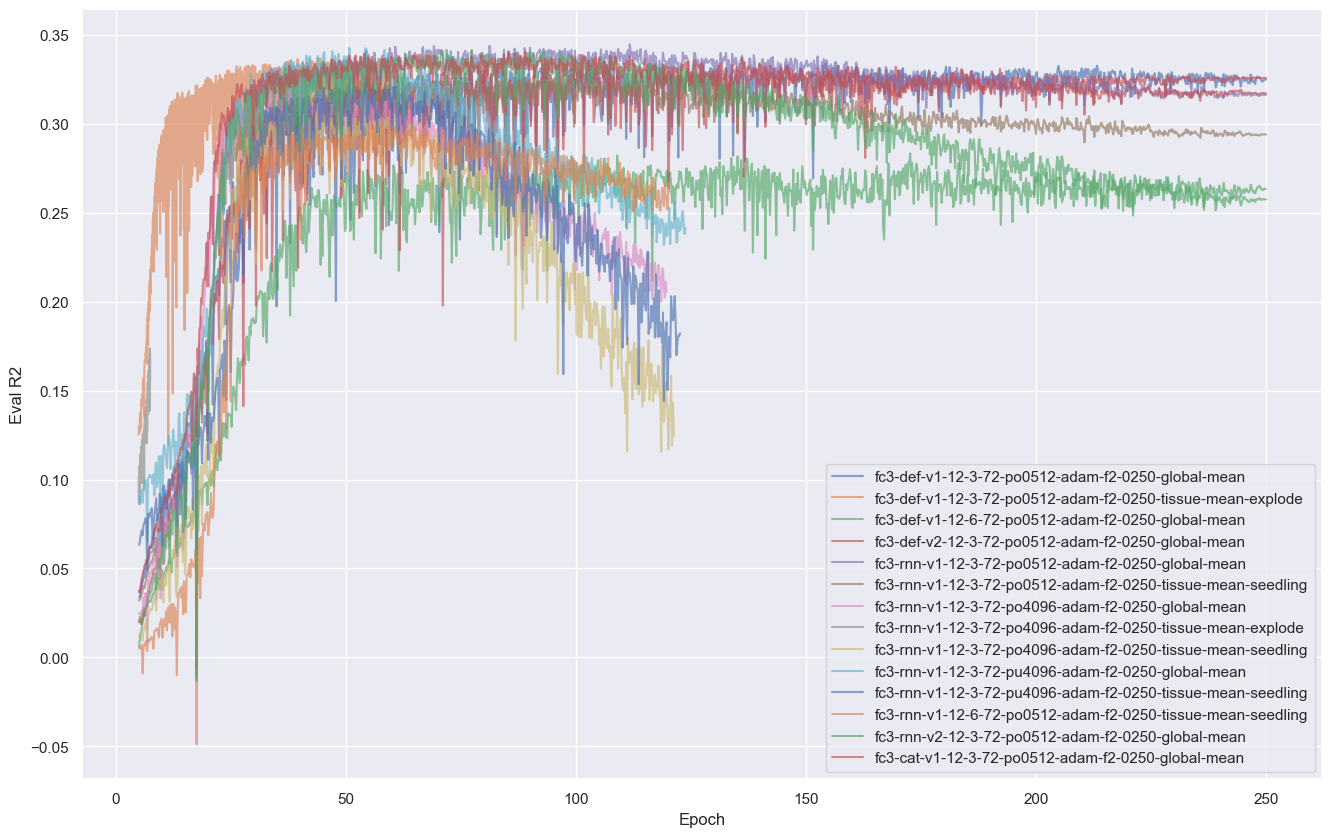

In [27]:
# Plot filter 2

report_plot.models_bert_r2(
	data = report_filter.filter_bert_reports(
		reports = report_bert_model,
		keep_only = ['f2'],
		drop_only = []
	),
	mode            = 'regression',
	step            = 'epoch',
	steps_min       = int(  5 * STEPS_PER_EPOCH),
	steps_max       = int(250 * STEPS_PER_EPOCH),
	steps_per_epoch = STEPS_PER_EPOCH,
	alpha           = 0.65,
	groupby         = 'none',
	filename        = os.path.join(DATA_DIR, 'bert-r2-f2')
)

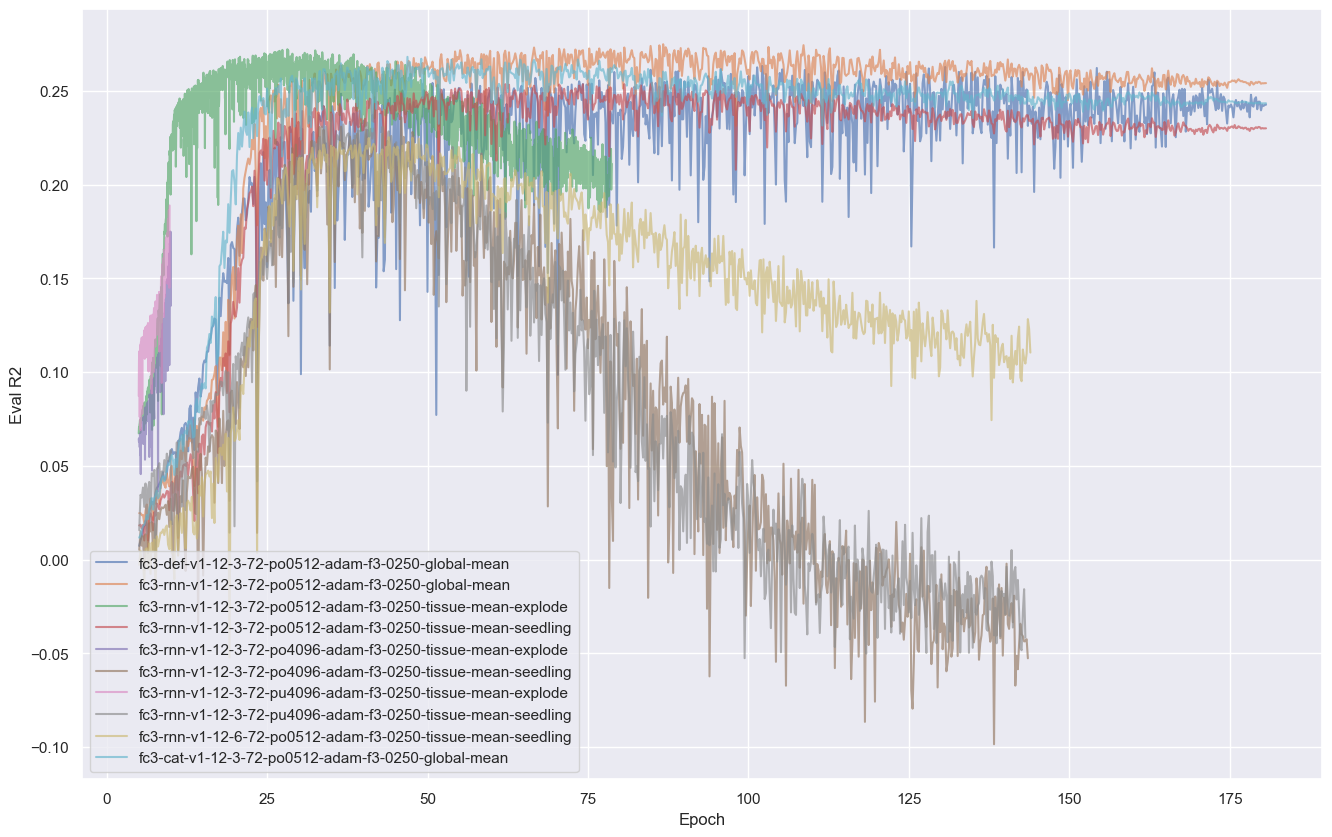

In [28]:
# Plot filter 3

report_plot.models_bert_r2(
	data = report_filter.filter_bert_reports(
		reports = report_bert_model,
		keep_only = ['f3'],
		drop_only = []
	),
	mode            = 'regression',
	step            = 'epoch',
	steps_min       = int(  5 * STEPS_PER_EPOCH),
	steps_max       = int(250 * STEPS_PER_EPOCH),
	steps_per_epoch = STEPS_PER_EPOCH,
	alpha           = 0.65,
	groupby         = 'none',
	filename        = os.path.join(DATA_DIR, 'bert-r2-f3')
)

### 3.1.2 Regression

In [29]:
# Concat reports and display top few

report = report_concat.concat_bert_reports(
	data            = report_bert_model,
	mode            = 'regression',
	metric          = 'eval_r2',
	ascending       = False,
	steps_per_epoch = STEPS_PER_EPOCH
)

if report is not None :
	report = report.drop(columns = ['Steps', 'Step'])
	report = report.reset_index(drop = True)
	report = report.head(n = 50)

report

,Mode,Arch,Pooler,Type,Layer,Kmer,Feature,Filter,Sequence,Optimizer,Target0,Target1,Target2,Eval_R2,Eval_ME,Eval_MAPE,Eval_MAE,LR,Epochs,Epoch
0,regression,fc3,def,rnn,12,3,72,f2,po0512,adam,global,mean,None,0.34468,3.02678,1.54737,0.59707,0.00003,250.0,111.7
1,regression,fc3,def,rnn,12,3,72,f2,pu4096,adam,global,mean,None,0.34270,3.29499,1.63542,0.59551,nan,123.8,50.8
2,regression,fc3,dna,rnn,12,3,72,f2,po0512,adam,global,mean,None,0.34154,2.93089,1.61402,0.59881,0.00004,250.0,71.9
3,regression,fc3,def,cat,12,3,72,f2,po0512,adam,global,mean,None,0.34046,3.08325,1.55781,0.59836,0.00004,250.0,89.1
4,regression,fc3,def,def,12,3,72,f2,po0512,adam,tissue,mean,explode,0.33763,3.30029,12.69585,0.63056,nan,59.8,59.7
5,regression,fc3,def,def,12,3,72,f2,po0512,adam,global,mean,None,0.33506,3.00240,1.61010,0.60534,0.00003,250.0,106.2
6,regression,fc3,dna,def,12,3,72,f2,po0512,adam,global,mean,None,0.33276,3.12639,1.58130,0.60313,0.00002,250.0,146.1
7,regression,fc3,def,rnn,12,3,72,f2,po0512,adam,tissue,mean,seedling,0.32664,3.20777,14.57904,0.61994,nan,250.2,66.8
8,regression,fc3,def,rnn,12,3,72,f2,pu4096,adam,tissue,mean,seedling,0.32656,3.30183,14.64238,0.62329,nan,122.7,54.3
9,regression,fc3,def,rnn,12,3,72,f2,po4096,adam,global,mean,None,0.32171,3.29793,1.68455,0.61259,nan,119.7,37.7


In [30]:
# Only for readability purpuses

report['Pooler'] = report['Pooler'].replace('def', 'default')
report['Pooler'] = report['Pooler'].replace('dna', 'dna')

report['Sequence'] = report['Sequence'].replace('po0512', 'TSS upstream  512bp')
report['Sequence'] = report['Sequence'].replace('po4096', 'TSS upstream 4096bp')
report['Sequence'] = report['Sequence'].replace('pu4096', 'CDS upstream 4096bp')
report

,Mode,Arch,Pooler,Type,Layer,Kmer,Feature,Filter,Sequence,Optimizer,Target0,Target1,Target2,Eval_R2,Eval_ME,Eval_MAPE,Eval_MAE,LR,Epochs,Epoch
0,regression,fc3,default,rnn,12,3,72,f2,TSS upstream 512bp,adam,global,mean,None,0.34468,3.02678,1.54737,0.59707,0.00003,250.0,111.7
1,regression,fc3,default,rnn,12,3,72,f2,CDS upstream 4096bp,adam,global,mean,None,0.34270,3.29499,1.63542,0.59551,nan,123.8,50.8
2,regression,fc3,dna,rnn,12,3,72,f2,TSS upstream 512bp,adam,global,mean,None,0.34154,2.93089,1.61402,0.59881,0.00004,250.0,71.9
3,regression,fc3,default,cat,12,3,72,f2,TSS upstream 512bp,adam,global,mean,None,0.34046,3.08325,1.55781,0.59836,0.00004,250.0,89.1
4,regression,fc3,default,def,12,3,72,f2,TSS upstream 512bp,adam,tissue,mean,explode,0.33763,3.30029,12.69585,0.63056,nan,59.8,59.7
5,regression,fc3,default,def,12,3,72,f2,TSS upstream 512bp,adam,global,mean,None,0.33506,3.00240,1.61010,0.60534,0.00003,250.0,106.2
6,regression,fc3,dna,def,12,3,72,f2,TSS upstream 512bp,adam,global,mean,None,0.33276,3.12639,1.58130,0.60313,0.00002,250.0,146.1
7,regression,fc3,default,rnn,12,3,72,f2,TSS upstream 512bp,adam,tissue,mean,seedling,0.32664,3.20777,14.57904,0.61994,nan,250.2,66.8
8,regression,fc3,default,rnn,12,3,72,f2,CDS upstream 4096bp,adam,tissue,mean,seedling,0.32656,3.30183,14.64238,0.62329,nan,122.7,54.3
9,regression,fc3,default,rnn,12,3,72,f2,TSS upstream 4096bp,adam,global,mean,None,0.32171,3.29793,1.68455,0.61259,nan,119.7,37.7
